In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nba_py import player
from nba_py import league
import seaborn as sns
%matplotlib inline

In [3]:
plt.style.use('seaborn-whitegrid')

In [4]:
import requests
headers = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'),  # noqa: E501
    'Dnt': ('1'),
    'Accept-Encoding': ('gzip, deflate, sdch'),
    'Accept-Language': ('en'),
    'origin': ('http://stats.nba.com')
    }


In [5]:
url_advanced = 'http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=10%2F23%2F2017&DateTo=10%2F29%2F2017&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='
url_shooting_eff = 'http://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=10%2F23%2F2017&DateTo=10%2F29%2F2017&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&PlayerExperience=&PlayerOrTeam=Player&PlayerPosition=&PtMeasureType=Efficiency&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='

In [6]:
def load_nba_dataset(json_data):
    result_data = json_data['resultSets'][0]
    headers = result_data['headers']
    shots = result_data['rowSet']
    data_frame = pd.DataFrame(data=shots, columns=headers)
    return data_frame

In [7]:
advanced_df = load_nba_dataset(requests.get(url_advanced, headers=headers).json())
shooting_df = load_nba_dataset(requests.get(url_shooting_eff, headers=headers).json())

In [8]:
oladipo_id = player.get_player('Victor', 'Oladipo')
cousins_id = player.get_player('DeMarcus', 'Cousins')
oladipo_id = oladipo_id.iloc[0]
cousins_id = cousins_id.iloc[0]

In [9]:
top_advanced = advanced_df.loc[(advanced_df.TS_PCT_RANK<70) & (advanced_df.MIN > 25) & (advanced_df.GP > 1)]

In [10]:
shooting_df = shooting_df.loc[(shooting_df.POINTS > 20) & (shooting_df.GP > 1) & (shooting_df.MIN>25)]

(19.8, 36.9)

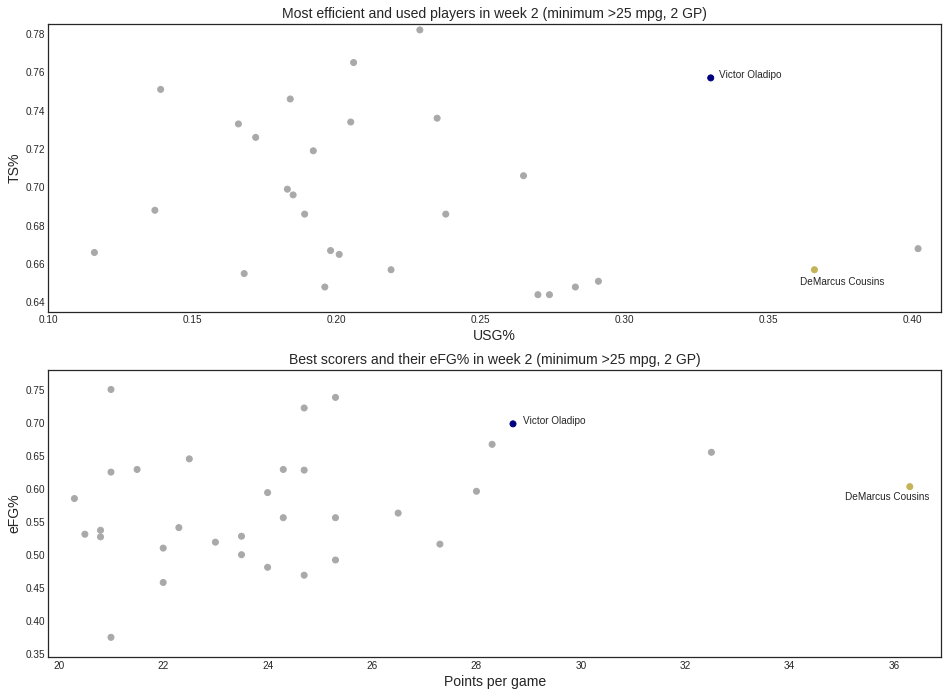

In [11]:
plt.style.use('seaborn-white')
plt.figure(figsize=(16, 18))

plt.subplot(311)
colors = []

for i in range(len(top_advanced)):
    if top_advanced.iloc[i].PLAYER_ID == oladipo_id:
        colors.append("#000080")
        plt.text(top_advanced.iloc[i].USG_PCT + 0.003, top_advanced.iloc[i].TS_PCT, top_advanced.iloc[i].PLAYER_NAME)
    elif top_advanced.iloc[i].PLAYER_ID == cousins_id:
        colors.append("#C5B358")
        plt.text(top_advanced.iloc[i].USG_PCT - 0.005, top_advanced.iloc[i].TS_PCT-0.008, top_advanced.iloc[i].PLAYER_NAME)
    else:
        colors.append("#A9A9A9")

plt.scatter(top_advanced.USG_PCT, top_advanced.TS_PCT, c=colors)
plt.xlabel('USG%', size=14)
plt.ylabel('TS%', size=14)
plt.title('Most efficient and used players in week 2 (minimum >25 mpg, 2 GP)', size=14)

plt.xlim(0.1, 0.41)
plt.ylim(0.635, 0.785)
plt.subplot(312)

colors = []
for i in range(len(shooting_df)):
    if shooting_df.iloc[i].PLAYER_ID == oladipo_id:
        colors.append("#000080")
        plt.text(shooting_df.iloc[i].POINTS + 0.2, shooting_df.iloc[i].EFF_FG_PCT, shooting_df.iloc[i].PLAYER_NAME)
    elif shooting_df.iloc[i].PLAYER_ID == cousins_id:
        colors.append("#C5B358")
        plt.text(shooting_df.iloc[i].POINTS - 1.25, shooting_df.iloc[i].EFF_FG_PCT-0.02, shooting_df.iloc[i].PLAYER_NAME)
    else:
        colors.append("#A9A9A9")

plt.scatter(shooting_df.POINTS, shooting_df.EFF_FG_PCT, c=colors)
plt.ylabel('eFG%', size=14)
plt.xlabel('Points per game', size=14)
plt.title('Best scorers and their eFG% in week 2 (minimum >25 mpg, 2 GP)', size=14)
plt.xlim(19.8, 36.9)


In [12]:
shooting_df['OTHER'] = np.clip(shooting_df.POINTS - shooting_df.DRIVE_PTS - shooting_df.CATCH_SHOOT_PTS - shooting_df.PULL_UP_PTS - shooting_df.POST_TOUCH_PTS - shooting_df.PAINT_TOUCH_PTS - shooting_df.ELBOW_TOUCH_PTS, a_min=0.0, a_max=None)

In [13]:
shooting_df = shooting_df.loc[(shooting_df.PLAYER_NAME != "Dennis Schroder") & (shooting_df.PLAYER_NAME != "Goran Dragic")]

In [14]:
interesting_players = ['DeMarcus Cousins', 'Victor Oladipo']
all_names = shooting_df.PLAYER_NAME.tolist()
cluster_list = [name if name in interesting_players else 'Other Players' for name in all_names]

shooting_df.PLAYER_NAME = cluster_list

shooting_data = shooting_df.sort_values(by='PLAYER_NAME', axis=0)

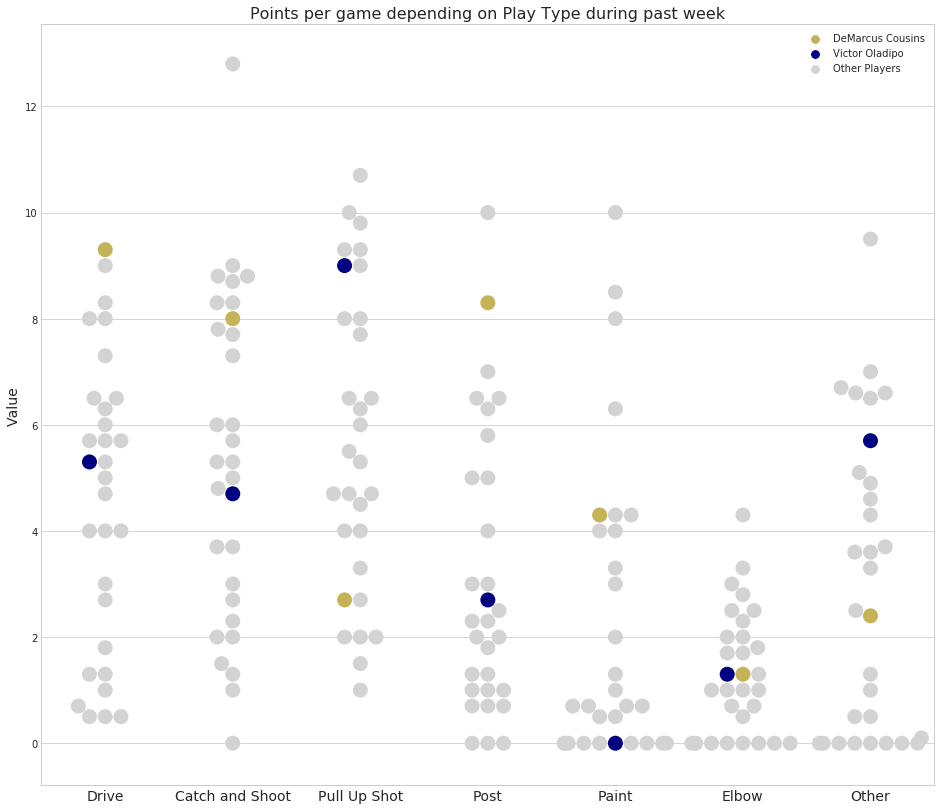

In [16]:
plt.figure(figsize=(16, 14))
colors = ["#C5B358", "#D3D3D3", "#000080"]
c_pal = sns.color_palette(colors)

melted_data = pd.melt(shooting_data, id_vars='PLAYER_NAME', value_vars=['DRIVE_PTS', 'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS', 'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS', 'OTHER'], var_name='Stat categories')
sns.set_style(style='whitegrid')
ax = sns.swarmplot(x='Stat categories', y='value', data=melted_data, hue='PLAYER_NAME', size=15, palette=c_pal)
ax.set_ylabel('Value', size=14)
ax.set_xlabel('')
ax.set_title('Points per game depending on Play Type during past week', size=16)
ax.set_xticklabels(["Drive", "Catch and Shoot", "Pull Up Shot", "Post", "Paint", "Elbow", "Other"], size=14)

handles, labels = ax.get_legend_handles_labels()
order = [0,2,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])